In [1]:
# Contributors:
# Richard C. (Rick) Gerkin converted the RMarkdown file used in the manuscript to a Python version
# See the original RMarkdown file for details on the original design and implementation of the analyses in R

In [2]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
sns.set(font_scale=1.5)
pd.set_option('mode.chained_assignment', None)  # Ignore SettingOnCopy warning

# Data loading and cleaning

In [3]:
# Database pulled on April 18th 8:34AM ET by Alyssa Joy Bakke, Penn State University
# Accessed on April 19th 4:00AM ET by Valentina Parma for first check
d = pd.read_csv('../data/raw_data/Covid_Results_GCCR001.csv')
n_initial = d.shape[0]

In [4]:
# Add ID column
d['ID'] = range(d.shape[0])

In [5]:
# Include only the relevant variables for the pre-registered GCCR001 analysis, posted at https://osf.io/auhs8/
# PYTHON CHANGE: removed 'ID' from this list as it does not exist yet.
keeps = ["Year_of_birth", "Country_of_Residence", "Gender", "Combustible_cigarette_use_no", "E-cigarette_use_no", "Symptoms_changes_in_smell",
         "COVID_diagnosis", "Smell_before_illness", "Smell_during_illness",
         "Changes_in_smell_i_cannot_smell_at_all_/_smells_smell_less_strong_than_they_did_before",
         "Changes_in_smell_smells_smell_different_than_they_did_before_(the_quality_of_smell_has_changed)",
         "Changes_in_smell_i_can_smell_things_that_aren't_there_(for_example_i_smell_burning_when_nothing_is_on_fire)",
         "Changes_in_smell_sense_of_smell_fluctuates_(comes_and_goes)", "Blocked_nose_before_illness", "Blocked_nose_during_illness",
         "Taste_before_illness", "Taste_during_illness", "Changes_in_basic_tastes_sweet", "Changes_in_basic_tastes_salty",
         "Changes_in_basic_tastes_sour", "Changes_in_basic_tastes_bitter", "Changes_in_basic_tastes_savory/umami", "Chemethesis_before_illness",
         "Chemesthesis_during_illness", "ID"]

d = d[keeps]

In [6]:
# Exclusion criteria. Missing values on smell, taste, chemesthesis ratings before and during
d = d[d['Smell_before_illness'].notnull() & 
      d['Smell_during_illness'].notnull() & 
      d['Taste_before_illness'].notnull() & 
      d['Taste_during_illness'].notnull() & 
      d['Chemethesis_before_illness'].notnull() & 
      d['Chemesthesis_during_illness'].notnull() & 
      d['Blocked_nose_before_illness'].notnull() &
      d['Blocked_nose_during_illness'].notnull()]

n_nomiss = d.shape[0]

In [7]:
# Create the change score
d['Smell_change'] = d['Smell_during_illness'] - d['Smell_before_illness']
d['Taste_change'] = d['Taste_during_illness'] - d['Taste_before_illness']
d['Chemesthesis_change'] = d['Chemesthesis_during_illness'] - d['Chemethesis_before_illness']
d['Nasal_occlusion_change'] = d['Blocked_nose_during_illness'] - d['Blocked_nose_before_illness']

In [8]:
# Simplify the visualization of variables
d['smell_loss'] = d['Changes_in_smell_i_cannot_smell_at_all_/_smells_smell_less_strong_than_they_did_before']
d['parosmia'] = d['Changes_in_smell_smells_smell_different_than_they_did_before_(the_quality_of_smell_has_changed)']
d['phantosmia'] = d["Changes_in_smell_i_can_smell_things_that_aren't_there_(for_example_i_smell_burning_when_nothing_is_on_fire)"]
d['smell_fluctuations'] = d['Changes_in_smell_sense_of_smell_fluctuates_(comes_and_goes)']

In [9]:
# Create a new summary sanity check variable
d['Gender'] = d['Gender'].replace({0: "Female",
                                   1: "Male",
                                   2: "Other",
                                   3: "Prefer not to say"})

d['Sanity_check'] = (((d['Symptoms_changes_in_smell'] == 1) & (d['Smell_change'] >= 5)) |
                     ((d['Symptoms_changes_in_smell'] == 1) & (d['Smell_change'] <= 5)) |
                     ((d['Symptoms_changes_in_smell'] == 1) & (d['smell_loss'] == 1)) |
                     ((d['Symptoms_changes_in_smell'] == 1) & (d['parosmia'] == 1)) |
                     ((d['Symptoms_changes_in_smell'] == 1) & (d['phantosmia'] == 1)) |
                     ((d['Symptoms_changes_in_smell'] == 1) & (d['smell_fluctuations'] == 1))).astype(int)         

In [10]:
# Create COVID-19 diagnostic groups
# COVID_diagnosis = 1 clinical examination
# COVID_diagnosis = 2 & 3 Lab tested
d['Group'] = d['COVID_diagnosis'].clip(1, 4).replace({1: "Clinical exam",
                                                      2: "Lab test",
                                                      3: "Lab test",
                                                      4: "Remove"})

In [11]:
d['Age'] = 2020 - d['Year_of_birth']
d = d[d['Age'] < 119]

In [12]:
keeps2 = ["Age", "Country_of_Residence", "Gender", "Combustible_cigarette_use_no", "E-cigarette_use_no", "COVID_diagnosis", "Smell_change",
          "Taste_change", "Chemesthesis_change", "Nasal_occlusion_change", "smell_loss", "parosmia", "phantosmia", "smell_fluctuations",
          "Changes_in_basic_tastes_sweet", "Changes_in_basic_tastes_salty", "Changes_in_basic_tastes_sour", "Changes_in_basic_tastes_bitter",
          "Changes_in_basic_tastes_savory/umami", "Sanity_check", "Group", "Smell_before_illness", "Smell_during_illness",
          "Blocked_nose_before_illness", "Blocked_nose_during_illness", "Taste_before_illness", "Taste_during_illness",
          "Chemethesis_before_illness", "Chemesthesis_during_illness"]
d = d[keeps2]
d = d.rename(columns={"Chemethesis_before_illness": "Chemesthesis_before_illness"})
d = d[d['Country_of_Residence'] != "TEST"]
n_testremove = d.shape[0]

In [13]:
# Create final database COVID-19 only
d = d[(d['Group'] == "Lab test") | (d['Group'] == "Clinical exam")]

In [14]:
d = d.join(pd.get_dummies(d['Gender']))
d = d.join(pd.get_dummies(d['Group']))
d = d.dropna()
n_final = d.shape[0]

In [15]:
d_clin = d[d['Group']=="Clinical exam"]
d_test = d[d['Group']=="Lab test"]
n_clin = d_clin.shape[0]
n_test = d_test.shape[0]

# Figure 1

In [16]:
s = pd.Series(index=['Raw Data', 'Remove Incomplete Data', 'Remove Mystyped Reponses',
                     'Final sample', 'COVID-19 Clinical Exam Sample', 'COVID-19 Lab Test Sample'],
              name = 'Sample Size (n)',
              data = [n_initial, n_nomiss, n_testremove, n_final, n_clin, n_test])
s.to_frame()

,Sample Size (n)
Raw Data,19035
Remove Incomplete Data,8269
Remove Mystyped Reponses,8267
Final sample,3856
COVID-19 Clinical Exam Sample,2539
COVID-19 Lab Test Sample,1317


In [17]:
age_mean = d['Age'].mean().round(2)
age_sd = d['Age'].std().round(2)
age_range = [d['Age'].min(), d['Age'].max()]

# Figure 2

In [18]:
def make_violin(d, sense, ax, legend=True):
    before = '%s_before_illness' % sense
    during = '%s_during_illness' % sense
    d_clean = d.rename(columns={before: 'Before', during: 'During'})
    d_clean = pd.melt(d_clean, value_vars=['Before', 'During'], id_vars='Group')
    g = sns.violinplot(x='variable', y='value', hue='Group', data=d_clean, ax=ax, add_legend=False, cut=0)
    if not legend:
        g.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylabel('Rating')
    ax.set_title(sense)

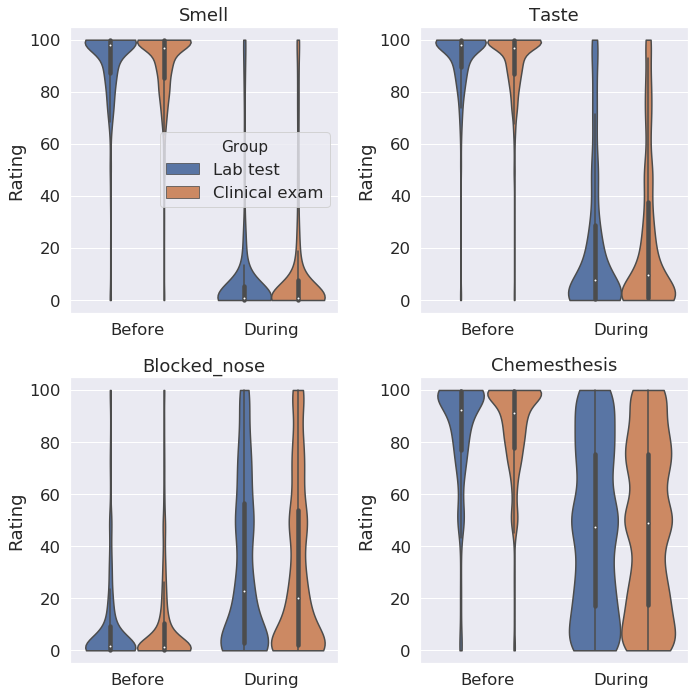

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, sense in enumerate(['Smell', 'Taste', 'Blocked_nose', 'Chemesthesis']):
    make_violin(d, sense, ax=axes.flat[i], legend=(i==0))
plt.tight_layout()

# FIGURE 3 - Characterization - Overall Changes

In [20]:
cols = ['Smell_change', 'smell_loss', 'smell_fluctuations',
        'Nasal_occlusion_change', 'Taste_change', 'Chemesthesis_change']
corrs = d[cols].corr().round(2)
corrs

,Smell_change,smell_loss,smell_fluctuations,Nasal_occlusion_change,Taste_change,Chemesthesis_change
Smell_change,1.00,-0.54,0.03,-0.05,0.44,0.27
smell_loss,-0.54,1.00,-0.24,0.01,-0.26,-0.16
smell_fluctuations,0.03,-0.24,1.00,0.02,0.03,0.00
Nasal_occlusion_change,-0.05,0.01,0.02,1.00,-0.07,-0.09
Taste_change,0.44,-0.26,0.03,-0.07,1.00,0.46
Chemesthesis_change,0.27,-0.16,0.00,-0.09,0.46,1.00


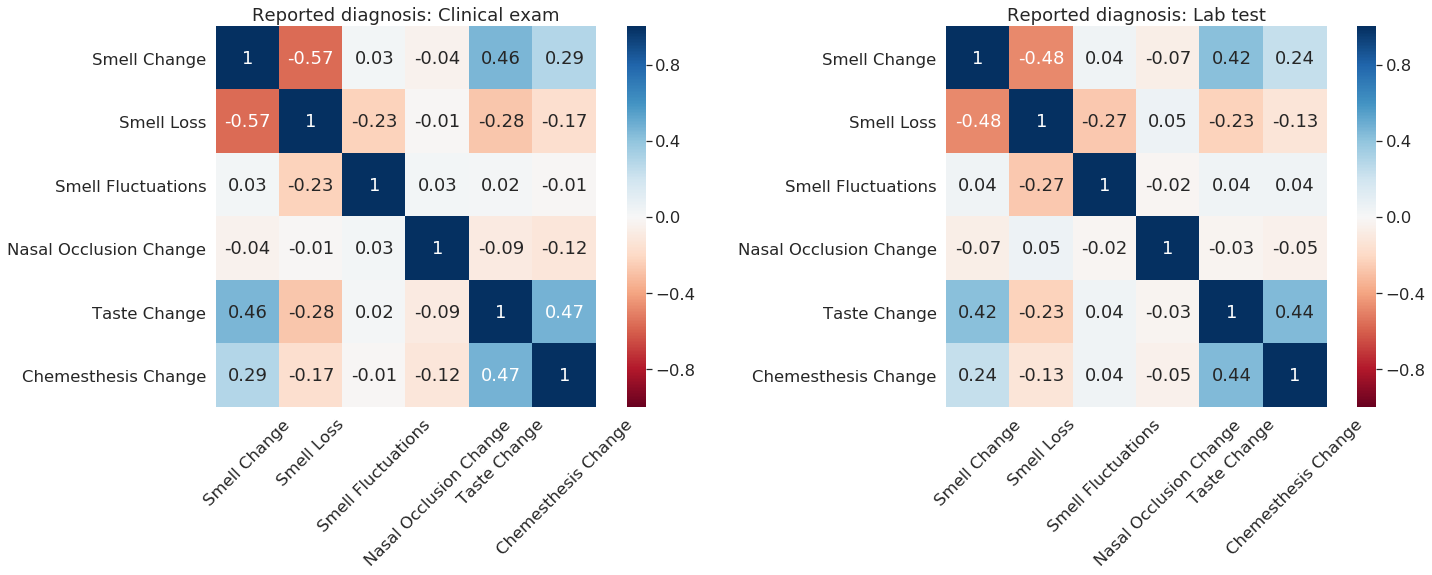

In [21]:
def make_corrmat(d, cols):
    fig, ax = plt.subplots(1, 2, figsize=(24, 7))
    for i, group in enumerate(['Clinical exam', 'Lab test']):
        d_group = d[d['Group']==group][cols]
        d_group.columns = d_group.columns.str.replace('_',' ').str.title().str.replace('Changes In Basic Tastes ', '')
        corrs = d_group.corr().round(2)
        sns.heatmap(corrs, vmin=-1, vmax=1, cmap='RdBu', square=True, annot=True, ax=ax[i])
        ax[i].set_xticklabels(d_group.columns, rotation=45)
        ax[i].set_title('Reported diagnosis: %s' % group)
        
make_corrmat(d, cols)

# FIGURE 4 - Chemosensory clustering

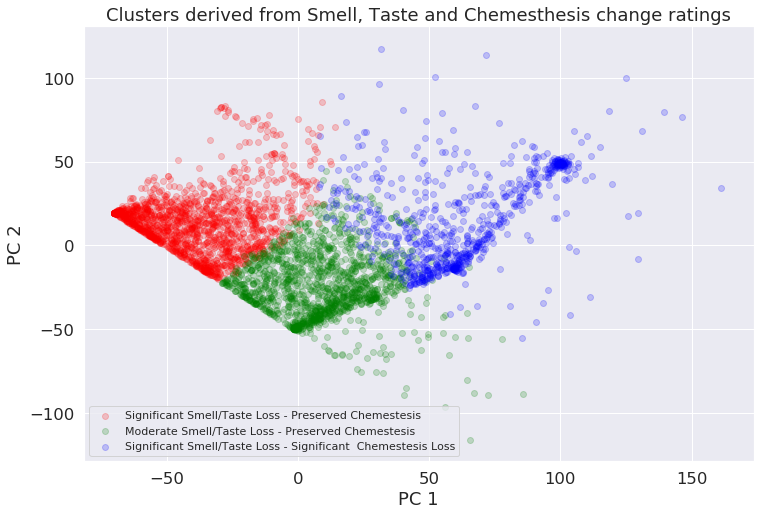

In [22]:
cols = ["Smell_change", "Taste_change", "Chemesthesis_change"]
k = KMeans(n_clusters=3, random_state=123)
pca = PCA(n_components=2)
coords = pca.fit_transform(d[cols])
k.fit(d[cols]);
k.labels_ += 1 # To match R
colors = {1: 'red', 2: 'green', 3: 'blue'}
labels = {1: "Significant Smell/Taste Loss - Preserved Chemestesis",
          2: "Moderate Smell/Taste Loss - Preserved Chemestesis",
          3: "Significant Smell/Taste Loss - Significant  Chemestesis Loss"}
plt.figure(figsize=(12, 8))
for i, color in colors.items():
    plt.scatter(*coords[k.labels_==i].T, c=color, alpha=0.2, label=labels[i])
plt.title('Clusters derived from Smell, Taste and Chemesthesis change ratings')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(fontsize=11);

# Supplemental Figures

In [23]:
def make_hist(d, sense, ax, add_legend=True):
    change = '%s_change' % sense
    for group in ['Clinical exam', 'Lab test']:
        d[d['Group']==group][change].hist(bins=50, alpha=0.5, ax=ax, label=group)
    ax.set_xlabel('')
    ax.set_ylabel('Rating')
    ax.set_title('Change in %s' % sense.replace(' ', '').title())
    if add_legend:
        ax.legend()

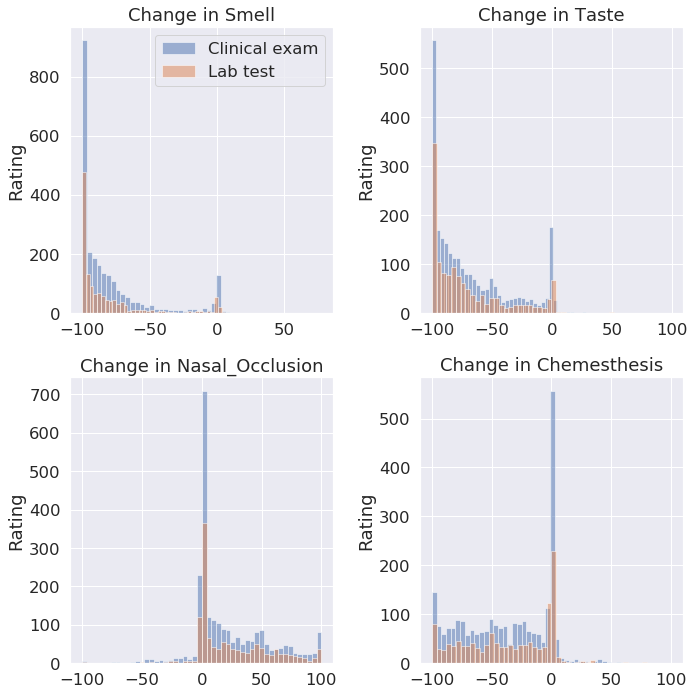

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, sense in enumerate(['Smell', 'Taste', 'Nasal_occlusion', 'Chemesthesis']):
    make_hist(d, sense, ax=axes.flat[i], add_legend=(i==0))
plt.tight_layout()

### Gender by Group

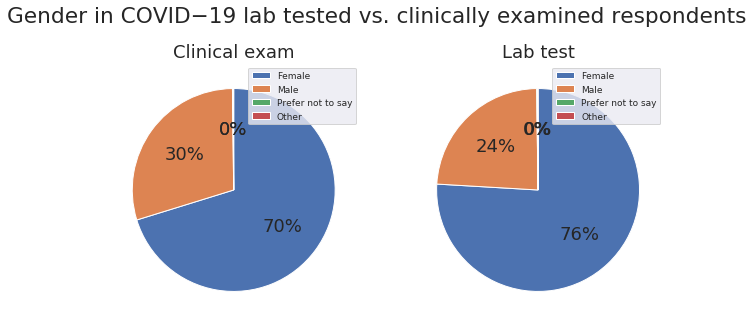

In [25]:
def pie_by_group(d, col):
    fig, axes = plt.subplots(1, 2, figsize=(10, 20))
    plt.suptitle('%s in COVID−19 lab tested vs. clinically examined respondents' % col.title(), y=0.63)
    for i, group in enumerate(['Clinical exam', 'Lab test']):
        d_group = d[d['Group']==group]
        gender = d_group[col].value_counts() / d_group.shape[0]
        labels = d_group[col].value_counts().index
        axes[i].pie(gender, autopct='%1.0f%%', startangle=90, counterclock=False)
        axes[i].set_title(group)
        axes[i].legend(labels, fontsize=9)
        
pie_by_group(d, 'Gender')

### Age by Group

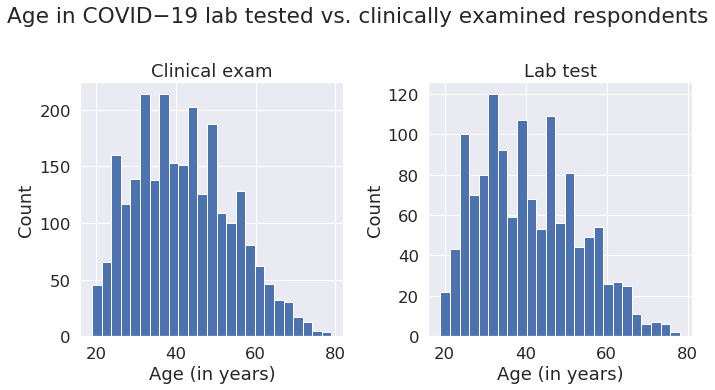

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, group in enumerate(['Clinical exam', 'Lab test']):
    axes[i].hist(d[d['Group']==group]['Age'], bins=25)
    axes[i].set_title(group)
    axes[i].set_xlabel('Age (in years)')
    axes[i].set_ylabel('Count')
plt.suptitle('Age in COVID−19 lab tested vs. clinically examined respondents', y=1.1)
plt.tight_layout()

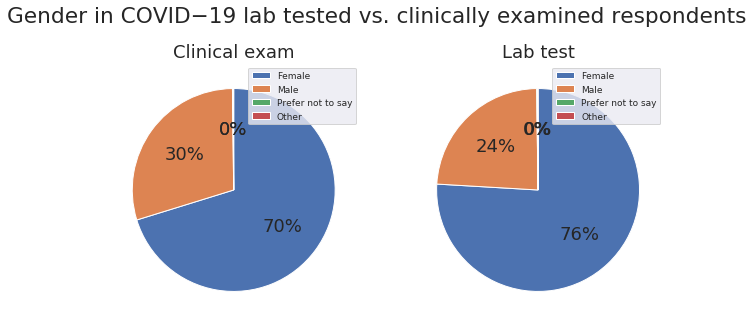

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 20))
plt.suptitle('Gender in COVID−19 lab tested vs. clinically examined respondents', y=0.63)
for i, group in enumerate(['Clinical exam', 'Lab test']):
    d_group = d[d['Group']==group]
    gender = d_group['Gender'].value_counts() / d_group.shape[0]
    labels = d_group['Gender'].value_counts().index
    axes[i].pie(gender, autopct='%1.0f%%', startangle=90, counterclock=False)
    axes[i].set_title(group)
    axes[i].legend(labels, fontsize=9)

### Characterization - Smell Change

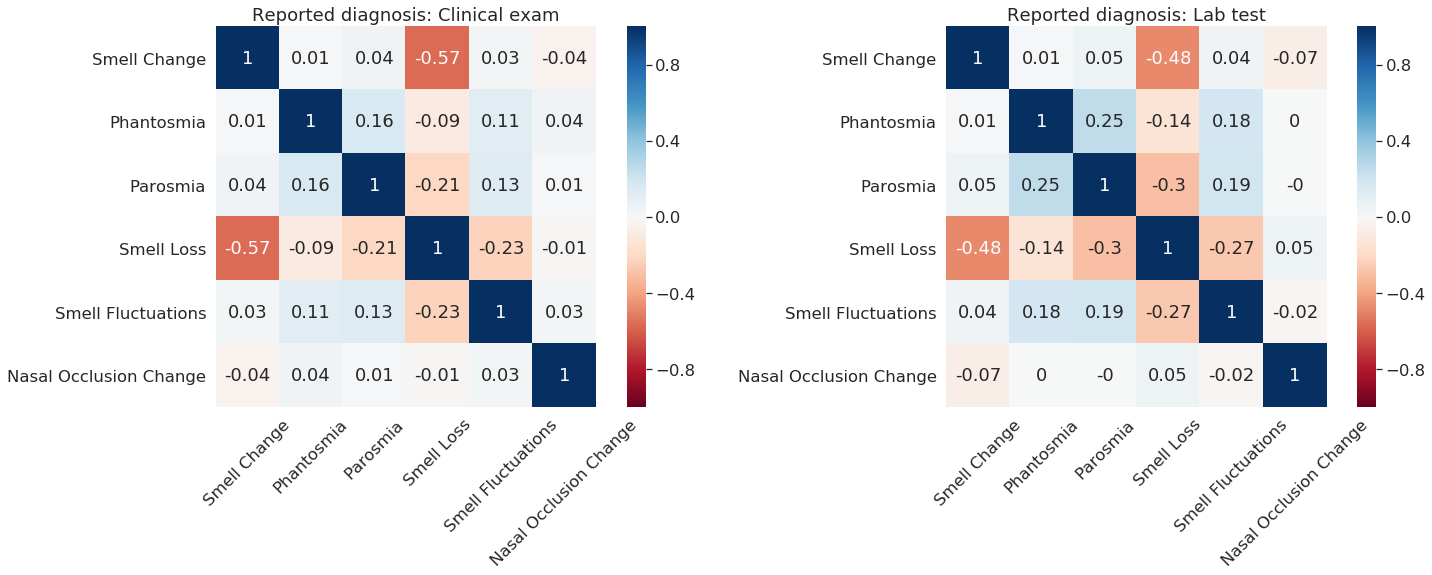

In [28]:
cols = ['Smell_change', 'phantosmia', 'parosmia', 'smell_loss', 'smell_fluctuations', 'Nasal_occlusion_change']
make_corrmat(d, cols)

### Characterization - Taste Change

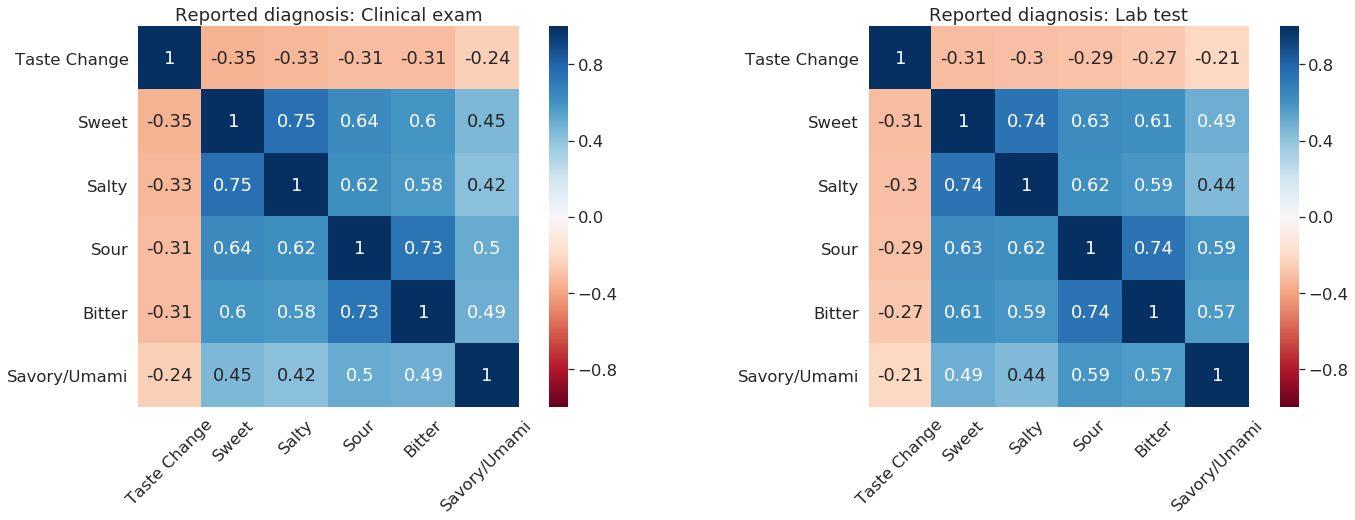

In [29]:
cols = ['Taste_change']
cols += ['Changes_in_basic_tastes_%s' % x for x in ['sweet', 'salty', 'sour', 'bitter', 'savory/umami']]
make_corrmat(d, cols)